# Аналитика в Яндекс.Афише

**Описание проекта:**
Вас пригласили на стажировку в отдел аналитики Яндекс.Афиши. Первое задание: помочь маркетологам оптимизировать маркетинговые затраты.

**Цели проекта**
Изучить:
- как люди пользуются продуктом,
- когда они начинают покупать,
- сколько денег приносит каждый клиент
- когда клиент окупается.

**Исходные данные:**
Данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.
/datasets/visits_log.csv /datasets/orders_log.csv /datasets/costs.csv

**Инструкция по выполнению проекта:**

**Шаг 1. Загрузите данные и подготовьте их к анализу**
Загрузите данные о визитах, заказах и расходах в переменные. Оптимизируйте данные для анализа. Убедитесь, что тип данных в каждой колонке — правильный. Путь к файлам: /datasets/visits_log.csv /datasets/orders_log.csv /datasets/costs.csv

**Шаг 2. Постройте отчёты и посчитайте метрики**
Отобразите на графиках, как эти метрики отличаются по устройствам и по рекламным источникам? Как они меняются во времени?
**Продукт**
Сколько людей пользуются в день, неделю, месяц?
Сколько сессий в день?
Сколько длится одна сессия?
Как часто люди возвращаются?
**Продажи**
Когда люди начинают покупать?
Сколько раз покупают за период?
Какой средний чек?
Сколько денег приносят? (LTV)
**Маркетинг**
Сколько денег потратили? Всего / на каждый источник / по времени
Сколько стоило привлечение одного покупателя из каждого источника?
На сколько окупились расходы? (ROI)

**Шаг 3. Напишите вывод: порекомендуйте маркетологам, куда и сколько им стоит вкладывать денег?**
Какие источники/платформы вы бы порекомендовали? Объясните свой выбор: на какие метрики вы ориентируетесь? Почему? Какие выводы вы сделали, узнав значение метрик?

**Описание данных:**
**Таблица visits (лог сервера с информацией о посещениях сайта):**
Uid — уникальный идентификатор пользователя
Device — категория устройства пользователя
Start Ts — дата и время начала сессии
End Ts — дата и время окончания сессии
Source Id — идентификатор рекламного источника, из которого пришел пользователь
**Таблица orders (информация о заказах):**
Uid — уникальный id пользователя, который сделал заказ
Buy Ts — дата и время заказа
Revenue — выручка Яндекс.Афиши с этого заказа
**Таблица costs (информация о затратах на маркетинг):**
source_id — идентификатор рекламного источника
dt — дата
costs — затраты на этот рекламный источник в этот день

In [1]:
# загрузка необходимых библиотек 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# настройка окружения
pd.options.display.max_columns = None
pd.options.display.float_format= '{:.2f}'.format
sns.set()

In [2]:
# импорт библиотек для прогресс-бара
import sys
import time

## Шаг 1. Загрузка данных и подготовка их к анализу

In [3]:
# загрузка исходных данных
df_visits = pd.read_csv('/datasets/visits_log.csv')
df_orders = pd.read_csv('/datasets/orders_log.csv')
df_costs = pd.read_csv('/datasets/costs.csv')

In [4]:
# знакомство с данными
display(df_visits.head())
df_visits.info()

,Uid,Device,End Ts,Source Id,Start Ts
0,16879256277535980062,touch,20.12.2017 17:38,4,20.12.2017 17:20
1,104060357244891740,desktop,19.02.2018 17:21,2,19.02.2018 16:53
2,7459035603376831527,touch,01.07.2017 1:54,5,01.07.2017 1:54
3,16174680259334210214,desktop,20.05.2018 11:23,9,20.05.2018 10:59
4,9969694820036681168,desktop,27.12.2017 14:06,3,27.12.2017 14:06


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358532 entries, 0 to 358531
Data columns (total 5 columns):
Uid          358532 non-null uint64
Device       358532 non-null object
End Ts       358532 non-null object
Source Id    358532 non-null int64
Start Ts     358532 non-null object
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [5]:
# названия столбцов с пробелом и заглавными буквами переименовываем (для удобства)
# все столбцы можно переименовать напрямую через columns, но через rename нагляднее и не перепутать порядок
df_visits.rename(columns={'End Ts': 'end_ts', 'Start Ts': 'start_ts', 'Source Id':'source_id', 
                          'Device': 'device', 'Uid': 'uid'}, inplace=True);

In [6]:
# выполняем преобразование данных в столбцах 'End Ts' и 'Start Ts' в формат  'datetime64'
# остальные данные имеют корректный формат. 
# пропущенные значения отсутствуют

# для ускорения обработки применяем ключ 'infer_datetime_format=True' и 'cache=True'
df_visits['end_ts'] = pd.to_datetime(df_visits['end_ts'], infer_datetime_format=True, cache=True)
df_visits['start_ts'] = pd.to_datetime(df_visits['start_ts'], infer_datetime_format=True, cache=True)

In [7]:
display(df_orders.head())
df_orders.info()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [8]:
# переименовываем столбцы с пробелом и заглавными буквами в названии 
df_orders.rename(columns={'Buy Ts': 'buy_ts', 'Revenue': 'revenue', 'Uid': 'uid'}, inplace=True);

In [9]:
# выполняем преобразование данных столбца 'Buy Ts'  в формат  'datetime64'
# остальные данные имеют корректный формат. 
# пропущенные значения отсутствуют
df_orders['buy_ts'] = pd.to_datetime(df_orders['buy_ts'], infer_datetime_format=True, cache=True) 

In [10]:
display(df_costs.head())
df_costs.info()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [11]:
# выполняем преобразование данных столбца 'dt'  в формат  'datetime64'
# данных о времени дня отсутствуют, отсекаем их в формате вывода
# остальные данные имеют корректный формат. 
# пропущенные значения отсутствуют
df_costs['dt'] = pd.to_datetime(df_costs['dt'], format='%Y-%m-%d') 

**Вывод: пропущенные записи в исходных данных отсутствуют, выполнено преобразование с временными данными к формату 'datetime64', столбцы с пробелом и заглавными литерами в названии переименованы.**

## Шаг 2. Построение отчётов и расчет метрик 
**Отобразить на графиках: как метрики отличаются по устройствам и по рекламным источникам? Как они меняются во времени?**

### **Продукт**
- Сколько людей пользуются в день, неделю, месяц? 
- Сколько сессий в день? 
- Сколько длится одна сессия? 
- Как часто люди возвращаются? 

**Подготовка данных**
В первую очередь добавляем столбец с длительностью сессии и проверяем данные. 

In [12]:
# добавляем столбец 'session_time' с длительностью сессии в минутах: 
df_visits['session_time'] = (df_visits['end_ts'] - df_visits['start_ts']).astype('timedelta64[m]')

In [13]:
# число записей отрицательной длительностью по утройствам:
print('Число сессий с отрицательной длительностью:', df_visits[df_visits['session_time'] < 0].shape[0])
print('Число сессий с нулевой длительностью:', df_visits[df_visits['session_time'] == 0].shape[0])
print('Общее число записей:', df_visits.shape[0])

Число сессий с отрицательной длительностью: 2
Число сессий с нулевой длительностью: 35794
Общее число записей: 358532


In [14]:
# длительность сесии не может быть отрицательной, таких записей всего 2 - удаляем
df_visits = df_visits[df_visits['session_time'] >= 0]
print('Общее число записей для исследования:', df_visits.shape[0])

Общее число записей для исследования: 358530


**Вывод:** в таблице df_visits присутствует 10% записей с нулевой длительностью сессии. Может быть связано с использованием поминутного счетчика времени. Реальное использование может быть действительно коротким - например открыть и "подсмотреть расписание". Большинство "нулевых" сессий при этом будет сосредоточено на мобильных устройствах. Данные оставляем.

##### Сколько людей пользуются в день, неделю, месяц (DAU, WAU, MAU)

In [15]:
# расчет вспомогательных столбцов 'ts_month', 'ts_week' с данными о месяце и неделе использования сервиса
df_visits['ts_date'] = df_visits['start_ts'].dt.date
df_visits['ts_week'] = (pd.to_datetime(df_visits['start_ts'], unit='d') 
                        - pd.to_timedelta(df_visits['start_ts'].dt.dayofweek, unit='d')).dt.date
df_visits['ts_month'] = df_visits['start_ts'].astype('datetime64[M]')

In [16]:
# среднее число уникальных пользователей в день:
print('Среднее число уникальных пользователей в день (DAU):',
int(df_visits.groupby('ts_date')['uid'].nunique().mean())     )

# среднее число уникальных пользователей в неделю:
print('Среднее число уникальных пользователей в неделю (WAU):',
int(df_visits.groupby('ts_week')['uid'].nunique().mean())     )

# среднее число уникальных пользователей в месяц:
print('Среднее число уникальных пользователей в месяц (MAU):',
int(df_visits.groupby('ts_month')['uid'].nunique().mean())     )

# sticky factor
print('Sticky Factor (DAU / MAU): {:.2%}'.format
(df_visits.groupby('ts_date')['uid'].nunique().mean()/
     df_visits.groupby('ts_month')['uid'].nunique().mean()) )

Среднее число уникальных пользователей в день (DAU): 907
Среднее число уникальных пользователей в неделю (WAU): 5716
Среднее число уникальных пользователей в месяц (MAU): 23228
Sticky Factor (DAU / MAU): 3.91%


**Вывод:** похоже пользователи редко возвращаются - **доля постоянных клиентов (Sticky Factor) 3,9% в месяц.**

##### Сколько сессий в день?

In [17]:
print('Среднее число сессий в день:',
    int(df_visits.groupby('ts_date')['uid'].count().mean())     )
print('Среднее число сессий в день для ПК:',
    int(df_visits[df_visits['device'].isin(['desktop'])].groupby('ts_date')['uid'].count().mean())     )
print('Среднее число сессий в день для моб. устройств:',
    int(df_visits[df_visits['device'].isin(['touch'])].groupby('ts_date')['uid'].count().mean())     )

Среднее число сессий в день: 984
Среднее число сессий в день для ПК: 719
Среднее число сессий в день для моб. устройств: 266


**Вывод:** Среднее число сессий - 886 близко к числу уникальных пользователей в день - 817, следовательно пользователи редко заходят на сервис повторно в течение суток. Версия ПК почти в три раза популярнее по просмотрам версии для моб.устройств, возможно возлагаемые на приложение задачи по просмотру удобнее решать через ПК.

##### Сколько длится одна сессия?

In [18]:
sess_describe = df_visits['session_time'].describe().reset_index()
sess_describe.rename(columns=({'session_time': 'both_devices'}), inplace=True)
sess_describe['desktop'] = df_visits[df_visits['device'].isin(['desktop'])]['session_time']\
    .describe().reset_index().session_time
sess_describe['touch'] = df_visits[df_visits['device'].isin(['touch'])]['session_time']\
    .describe().reset_index().session_time
sess_describe

,index,both_devices,desktop,touch
0,count,358530.00,261911.00,96619.00
1,mean,10.74,11.75,8.01
2,std,16.63,17.80,12.55
3,min,0.00,0.00,0.00
4,25%,2.00,2.00,1.00
5,50%,5.00,6.00,3.00
6,75%,14.00,15.00,10.00
7,max,711.00,711.00,514.00


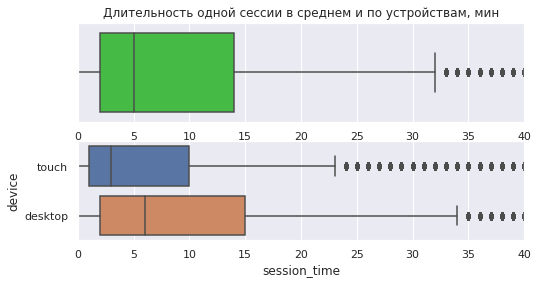

In [19]:
fig, axes = plt.subplots(2, 1, figsize=(8, 4))
sns.boxplot(df_visits['session_time'], color='limegreen', ax=axes[0])
sns.boxplot(y='device', x='session_time', data=df_visits[df_visits['device']
            .isin(['touch', 'desktop' ])], orient='h')
# настройка отображения
axes[0].set_xlim(0, 40)
axes[1].set_xlim(0, 40)
axes[0].set_title('Длительность одной сессии в среднем и по устройствам, мин');

**Вывод:** В выборке присутствуют выбросы по длительности сессии (до 711 мин., почти 12 часов), это основание для баг-репорта. Возможно не учитывается реальная активность пользователей на странице сервиса. Разница может возникать также из-за отличия в целях использования: только покупка билетов на уже выбранное мероприятие или полноценное изучение афиши и рецензий. Для характеристики в данном случае лучше использовать медиану вместо среднего. **Типовая длительность одной сесиии - 5 мин. Время просмотра с ПК значительно больше чем с мобильных устройств: медианы 6 мин и 3 мин соответственно.**

##### Как часто люди возвращаются?

In [20]:
# Доля пользователей совершивших повторный визит (не менее 2 визитов), %:
print('Общее число уникальных пользователей: {:.0f}'.format(( df_visits['uid'].nunique())))
print('Число повторных визитов: {:.0f}'.format((df_visits['uid'].value_counts() >=2).sum()))
print('Процентная доля повторных визитов: {:.2%}'
      .format((df_visits['uid'].value_counts() >=2).sum() /  df_visits['uid'].nunique()))

Общее число уникальных пользователей: 228169
Число повторных визитов: 51586
Процентная доля повторных визитов: 22.61%


**Вывод:** Повторный визит совершает только пятая часть посетителей.

### **Продажи**
- Когда люди начинают покупать? 
- Сколько раз покупают за период? 
- Какой средний чек? 
- Сколько денег приносят? 

**Подготовка данных:**

In [21]:
# определяем когда пользователи первый раз посетили сервис и когда сделали первую покупку
s_first_ts = df_visits.groupby('uid')['start_ts'].min().reset_index()
s_first_buy = df_orders.groupby('uid')['buy_ts'].min().reset_index()
s_first_ts.columns = ['uid', 'first_ts']
s_first_buy.columns = ['uid', 'first_buy']

In [22]:
# объединяем данные о первом использовании сервиса и первом заказе с таблицей заказов
df_orders = df_orders.merge(s_first_ts)
df_orders = df_orders.merge(s_first_buy)

In [23]:
# расчет столбца 'delay_to_buy' - время между первым визитом и первой покупкой, мин.
df_orders['delay_to_buy'] = (df_orders['first_buy'] - df_orders['first_ts']).astype('timedelta64[m]')

In [24]:
# после объединения таблиц выполняем проверку полученных данных 
# дата и время первого визита на сервис не могут быть позже даты и времени первого заказа
# подсчет числа записей, где это условие не выполняется
print('Число записей с ошибочными данными о времени сессии:', df_orders[df_orders['delay_to_buy'] < 0].shape[0])
print('Общее число записей:', df_orders.shape[0])

Число записей с ошибочными данными о времени сессии: 1964
Общее число записей: 50415


**4% ошибочных данных,** где момент первого визита позже времени первого заказа. Это основание для баг-репорта. Удалить эти записи нельзя - это исказит показатели выручки по проекту. В исследованиях, где учитывается время между визитом и заказом, будем отсеивать данные по этому критерию.

##### Когда люди начинают покупать?

В исходной выгрузке логов нет данных о дате/времени первой регистрации пользователей. Мы можем лишь оценить время между первой покупкой пользователя (считаем ее регистрацией) и первой сессией на сервисе. 

In [25]:
# подготовка данных для графиков
# группировка по пользователям - интервал до первой покупки 
# данные с отрицательным временем между регистраций и покупкой отсекаем
df_first_orders = df_orders[df_orders['delay_to_buy'] > 0].groupby('uid')['delay_to_buy'].mean()

count    34068.00
mean     26094.17
std      69857.87
min          1.00
25%          5.00
50%         21.00
75%       4438.00
max     523144.00
Name: delay_to_buy, dtype: float64

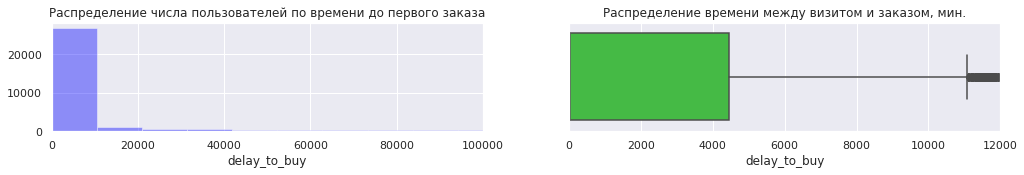

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(17, 2))

axes[0].set_title('Распределение числа пользователей по времени до первого заказа');
sns.distplot(df_first_orders, color='blue', kde=False,  ax=axes[0])
#axes[0].set_yscale('log')
axes[0].set_xlim([0, 100000]);

axes[1].set_title('Распределение времени между визитом и заказом, мин.')
sns.boxplot(df_first_orders, color='limegreen', ax=axes[1])
axes[1].set_xlim([0, 12000]);

df_first_orders.describe()

**Вывод:**  25% покупок соврешаются в течение 5 мин., 50% в течение 21 мин., 75% в течение 3 дней от момента первого использования. Некоторые пользователи принимают решение долгие месяцы.

##### Сколько раз покупают за период?

Для ответа на вопрос можно применить когортный анализ. Поскольку имеются данные за год, используем месячный интервал для анализа. Фильтрацию данных на соответствие времени визита и покупки - не применяем.

In [27]:
# добавляем необходимые для группировки данные
# добавляем столбец 'first_buy_ts_month' - месяц первой покупки
df_orders['first_buy_ts_month'] = df_orders['first_buy'].astype('datetime64[M]').dt.date
# добавляем столбец 'buy_ts_month' - месяц покупки
df_orders['buy_ts_month'] = df_orders['buy_ts'].astype('datetime64[M]').dt.date

In [28]:
pt_orders_by_month = ( df_orders.loc[df_orders['buy_ts'] < '2018-06-01'] # отсекаем единственную покупку от 01.06.2018
    .pivot_table(
    index='first_buy_ts_month',
    columns='buy_ts_month',
    values='uid',
    aggfunc='count',
    margins=True))

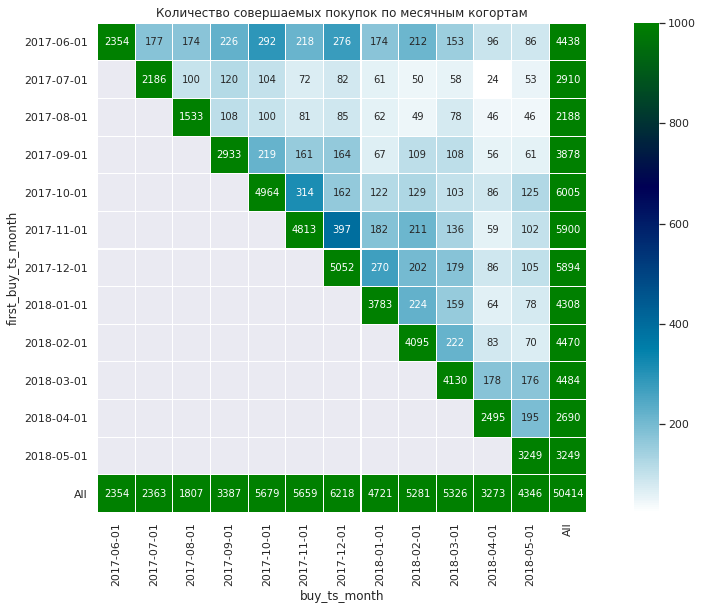

In [29]:
plt.figure(figsize=(17, 9))
sns.heatmap(pt_orders_by_month, annot=True, fmt=".0f", linewidths=.1, square=True , vmax =1000, cmap='ocean_r')
plt.title('Количество совершаемых покупок по месячным когортам');

**Вывод:** количество повторных покупок резко падает на второй месяц по всем когортам. С октября 2017 наблюдается резкий, почти двукратный, рост покупок и столь же сильное снижение числа покупок в апреле 2018г.  

##### Какой средний чек?

In [30]:
# Определяем средний чек как общую стоимость всех заказов деленную на общее число заказов 
print('Сумма среднего чека: {:.2F} у.е.'.format(df_orders.revenue.sum() / df_orders.shape[0]))
print('Общая выручка за весь период: {:.2F} у.е.'.format(df_orders.revenue.sum()))

Сумма среднего чека: 5.00 у.е.
Общая выручка за весь период: 252057.20 у.е.


**Вывод: средний чек равен 5.01 у.е.** / название денежной единицы в задании не указано, используем у.е. 

##### Сколько денег приносят? (LTV)

Возможен короткий ответ на этот вопрос (расчет средней стоимости заказов  за весь период) и развернутый, с разделением клиентов по когортам и помесячным анализом. Выполняем оба варианта.

**1. Средний LTV за весь период.**

In [31]:
# Определяем LTV как среднее стоимости заказов клиентов за весь период 
print('Средний LTV: {:.2F} у.е.'.format(df_orders.groupby('uid')['revenue'].sum().mean()))

Средний LTV: 6.90 у.е.


**Средний LTV 6.93 у.е. близок к стоимости среднего чека 5.01 у.е. это подтверждает, что большинство покупок в сервисе разовые, клиенты редко возвращаются.**

**2. LTV по месячным когортам**

In [32]:
pt_revenue_by_month = ( df_orders.loc[df_orders['buy_ts'] < '2018-06-01'] # отсекаем единственную покупку от 01.06.2018
    .pivot_table(
    index='first_buy_ts_month',
    columns='buy_ts_month',
    values='revenue',
    aggfunc='sum',
    margins=True))

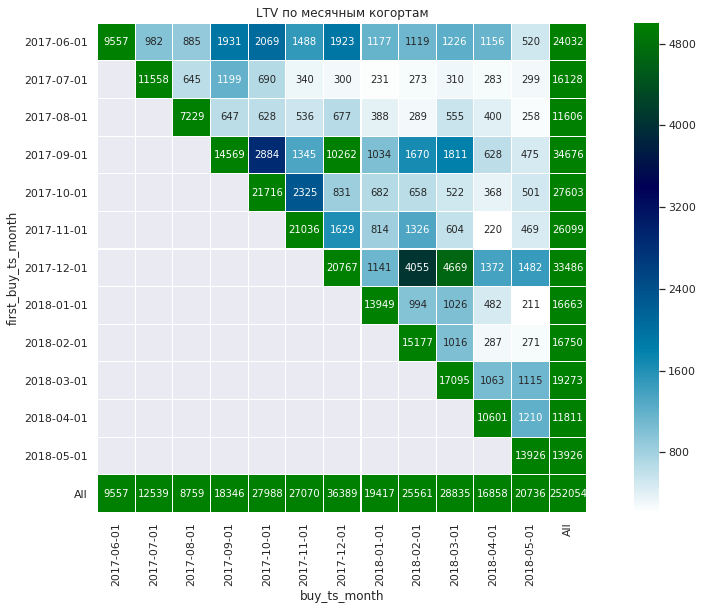

In [33]:
plt.figure(figsize=(17, 9))
sns.heatmap(pt_revenue_by_month, annot=True, fmt=".0f", linewidths=.1, square=True , vmax =5000, cmap='ocean_r')
plt.title('LTV по месячным когортам');

**Вывод:** Для объема реальной выручки от покупок картина более оптимистична чем для количества повторных покупок. Скорее всего повторные покупки имеют большую чек. Выделяется когорта сентября 2017г, для которой в декабре 2017 месячный объем покупок достиг 71% от покупок первого месяца. Пик объема продаж приходится на декабрь 2017 с резким спадом в январе, возможно влияет фактор новогодних праздников.

### ** Маркетинг** 
- Сколько денег потратили? Всего / на каждый источник / по времени 
- Сколько стоило привлечение одного покупателя из каждого источника?
- На сколько окупились расходы? (ROI) 

**Подготовка данных - 1 Этап**

Выявлено несоответствие данных в таблице визитов и заказов. Момент оформления заказа должен быть между началом и концом сессии, это условие не выполняется. Задача слияния таблиц осложняется также тем, что некоторые заказы приходили из разных источников рекламы для одного и того же пользователя: 

In [34]:
print('Источников рекламы в использовании:', df_costs.source_id.nunique())

Источников рекламы в использовании: 7


In [35]:
#df_costs.pivot_table(index='dt', columns='source_id', values='costs', aggfunc='sum')
for source in range(1, 8):
    print('Пользователей пришедших от {} ист. рекламы: {}'
          .format(source, (df_visits.groupby('uid')['source_id'].nunique() > source).sum()))

Пользователей пришедших от 1 ист. рекламы: 37720
Пользователей пришедших от 2 ист. рекламы: 9078
Пользователей пришедших от 3 ист. рекламы: 2286
Пользователей пришедших от 4 ист. рекламы: 525
Пользователей пришедших от 5 ист. рекламы: 83
Пользователей пришедших от 6 ист. рекламы: 9
Пользователей пришедших от 7 ист. рекламы: 0


Нужно объединить данных о сессиях и заказах. Данные об источнике рекламы есть только в таблице df_visits, связка с df_orders только по уникальному номеру пользователя uid даст ошибки, поскольку источники рекламы для одного пользователя могут быть разными. Выполняем слияние таблиц по uid и последующую фильтрацию по условию:  время заказа должно быть после начала сессии и до ее окончания.

In [36]:
# создаем поле для идентификации заказов в orders_id из индекса
df_orders['orders_id'] = df_orders.index
print('Исходное число записей в df_orders:', df_orders.shape[0])
# объединяем df_orders и df_visits, на  этом этапе записи многократно дублируются
# для подходящих записей из df_visits в df_orders_new добавляется:
# номер источника рекламы, устройство, время начала и конца сессии.
df_orders_new = df_orders.merge(df_visits[['uid', 'device', 'source_id', 'start_ts', 'end_ts']], on='uid', how='left')
print('Число записей после слияния в df_orders_new:', df_orders_new.shape[0])

# основной цикл обработки таблицы df_orders_new
# выполняется проверка: равенство uid покупателя, время покупки должно быть в рамка времени визита
df_orders_new = df_orders_new.where(
    ((df_orders_new['start_ts'] <= df_orders_new['buy_ts']) & (df_orders_new['buy_ts'] <= df_orders_new['end_ts'])), axis=1 )

# удаляем строки которые не соответствовали условию и теперь имеют значение NaN
df_orders_new = df_orders_new.dropna()
print('Число записей df_orders_new после проверки по условию:', df_orders_new.shape[0])

Исходное число записей в df_orders: 50415
Число записей после слияния в df_orders_new: 759843
Число записей df_orders_new после проверки по условию: 35059


In [37]:
# список заказов для которых не выполняется условие по соответствию времени заказа и времени сессии 
list_of_bad = set(df_orders['orders_id']).difference(set(df_orders_new['orders_id']))
print('Число ошибочных записей оставшихся в df_orders:', len(list_of_bad))

Число ошибочных записей оставшихся в df_orders: 15356


**Подготовка данных - 2 Этап**

В таблице df_orders остается 15356 записей без данных о источнике рекламы и устройстве доступа. Поскольку данных о времени сессии для них нет, выбираем данные **при первом визите пользователя**. Такой перенос значений можно применить и ко всей таблице df_orders, **без использования предыдущей обаботки,** но это может дать ошибку в оценке эффективности разных источников рекламы.

In [38]:
# контроль осуществляем по числу уникальных записей после обработки
# в итоговой таблице число записей должно совпасть с числом UID в df_visits
print('Общее число уникальных UID в df_visits:', df_visits['uid'].nunique())

# делаем отбор по первому визиту и формируем df с источниками и устройствами 
df_source_id = df_visits.groupby(['uid', 'device', 'source_id'])['start_ts'].min().reset_index()
print('Записей после первой группировки (первый визит):', df_source_id.shape[0])

# группировка по устройствам, отсекаются лишние записи если пользователь использует одно устройство 
# источник рекламы выбирается по минимальному его номеру - возможный источник ошибок
df_source_id = df_source_id.groupby(['uid', 'device'])['source_id'].min().reset_index()
print('Записей после второй группировки (выбор источника рекламы):', df_source_id.shape[0])

# для оставшихся записей создаем список пользователей использующих два устройства
# по предыдущим исследованиям ПК используется клиентами чаще, поэтому делаем замену на ПК
uid = (df_source_id.groupby('uid')['device'].count() > 1).reset_index()
uid = list(uid[uid['device']==True].uid)

# окончательная обработка - отсев записей дублеров
df_source_id = df_source_id.loc[~(df_source_id['device'].isin(['touch']) & df_source_id['uid'].isin(uid))]
print('Записей после третьей группировки (из двух устройств - ПК):', df_source_id.shape[0])

Общее число уникальных UID в df_visits: 228169
Записей после первой группировки (первый визит): 282165
Записей после второй группировки (выбор источника рекламы): 235868
Записей после третьей группировки (из двух устройств - ПК): 228169


Таблица с данными подготовлена, число записей совпадает, можно объединять с таблицей заказов  df_orders.

In [39]:
# фактически таблица заказов на данный момент разделена на 2
# с заполненными данными по источникам df_orders_new и без 
# делим таблицу заказов на две: с заполненными данными по источнику рекламы df_2 и без df_orders_bad
#print(df_orders.shape[0], df_orders.revenue.sum()) # контральные данные
df_orders_bad = df_orders[df_orders['orders_id'].isin(list_of_bad)]
#print(df_orders_bad.shape[0] + df_orders_new.shape[0]) # контральные данные

# добавляем недостающую информацию полученную в предыдущем вычислении, переименовываем столбцы
df_orders_bad = df_orders_bad.merge(df_source_id, on='uid')
#print(df_orders_bad.shape[0] + df_orders_new.shape[0]) # контральные данные

# обратное слияние "половинок" в полную таблицу заказов df_orders_new
df_orders_new = pd.concat([df_orders_bad, df_orders_new], sort=False)
#print(df_orders_new.shape[0], df_orders_new.revenue.sum()) # контральные данные

Данные для анализа подготовлены.

#### Сколько денег потратили? Всего / на каждый источник / по времени 

In [40]:
df_costs['dt_month'] = df_costs['dt'].astype('datetime64[M]').dt.date

In [41]:
pt_costs_source = df_costs.pivot_table(
    index = 'source_id',
    columns = 'dt_month',
    values = 'costs',
    aggfunc = 'sum',
    margins=True)

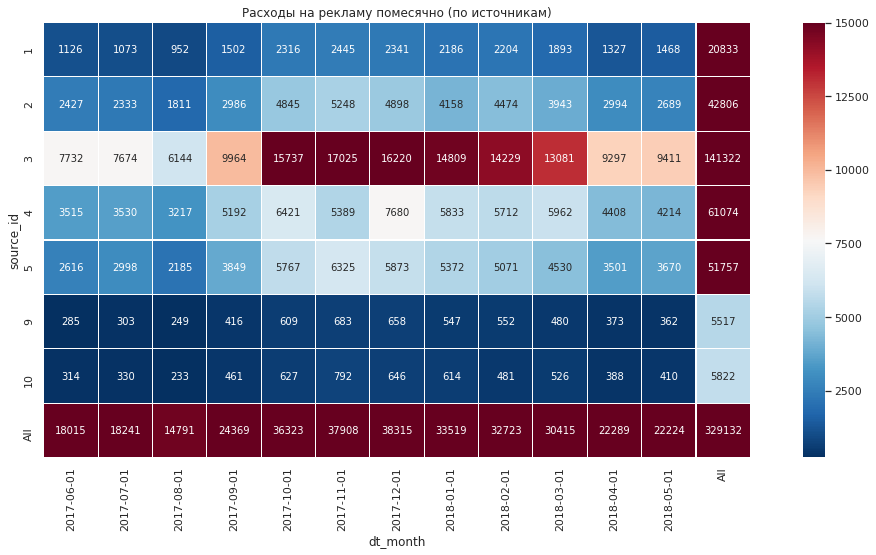

In [42]:
plt.figure(figsize=(17, 8))
sns.heatmap(pt_costs_source, annot=True, fmt=".0f", linewidths=.1, square=True , vmax = 15000, cmap='RdBu_r')
plt.title('Расходы на рекламу помесячно (по источникам)');

**Вывод:** Наибольшие затраты на рекламу, почти 50% от общей суммы, сервис несет по 3 источнику. Насколько они эффективны станет ясно позднее.

#### Сколько стоило привлечение одного покупателя из каждого источника?

Судя по данным одни и те же покупатели делали покупки при переходе из разных источников рекламы. Поэтому расчет удельных затрат делаем в разрезе соврешенной покупки, а не уникального покупателя.

In [43]:
# число покупок по разным источникам рекламы помесячно
# отсекаем единственную покупку от 01.06.2018
pt_orders_count = df_orders_new.loc[df_orders_new['buy_ts'] < '2018-06-01'].pivot_table( 
    index = 'source_id',
    columns = 'buy_ts_month',
    values = 'revenue',
    aggfunc = 'count',
    margins=True)

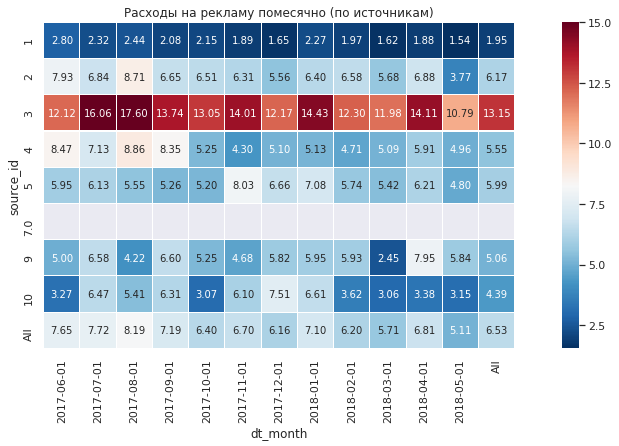

In [44]:
plt.figure(figsize=(17, 6))
sns.heatmap((pt_costs_source / pt_orders_count), annot=True, fmt=".2f",
            linewidths=.1, square=True , vmax = 15, cmap='RdBu_r')
plt.title('Расходы на рекламу помесячно (по источникам)');

**Вывод:** Наибольшие удельные затраты на один заказ приходятся на 3 усточник - 13.15 у.е. на один заказ. Самые низкие у источника 1 - 1.95 у.е. Источник с номером 7 выделяется тем, что от него поступил 1 заказ за весь период, при этом данные о стоимости отсутствуют. Учитывая, что средний LTV 6.93 у.е., а средний чек 5.01 у.е., можно сделать отбор эффективных источников рекламы по уменьшению приоритета: 1, 10, 9, 4, 5, 2. 

#### На сколько окупились расходы? (ROMI)

В задании требуется посчитать показатель ROI, однако по предоставленным данным можно посчитать только возврат на маркетинговые инвестиции ROMI. Его и считаем.
Расчет делаем по упрощенной формуле: ROMI рекламной кампании = валовая прибыль из этой кампании / затраты

In [45]:
# число покупок по разным источникам рекламы помесячно
# отсекаем единственную покупку от 01.06.2018
pt_marketing_revenue = df_orders_new.loc[df_orders_new['buy_ts'] < '2018-06-01'].pivot_table( 
    index = 'source_id',
    columns = 'buy_ts_month',
    values = 'revenue',
    aggfunc = 'sum',
    margins=True)

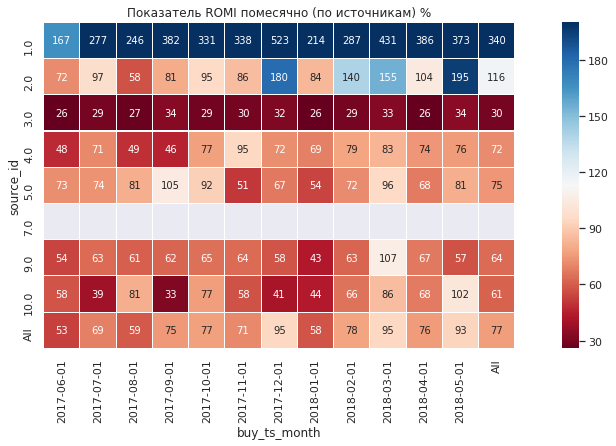

In [46]:
plt.figure(figsize=(17, 6))
sns.heatmap((pt_marketing_revenue / pt_costs_source * 100), annot=True, fmt=".0f",
            linewidths=.1, square=True , vmax = 200, cmap='RdBu')
plt.title('Показатель ROMI помесячно (по источникам) %');

Дополнительно оцениваем объем выручки с разных типов устройств. Ранее это нельзя было сделать из-за отсутствия необходимых данных в таблице df_orders.

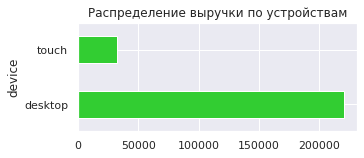

In [47]:
plt.figure(figsize=(5, 2 ))
df_orders_new.groupby(['device'])['revenue'].sum().plot(kind='barh', color='limegreen')
plt.title('Распределение выручки по устройствам');

**Вывод:** На рассматриваемой стадии проект Яндекс.Афиша убыточен. Возможной причиной могут быть завышенные затраты на маркетинг, особенно по источнику '3' где затраты в 4 раза превышают выручку. Вместе с тем реклама по источникам 1 и 2 дает положительный эффект. Наибольший ROMI до 523% дает реклама в источнике 1. Общий ROMI за весь период составляет 77%. Наибольшую выручку дают заказы с ПК, в 7 раз больше чем с мобильных устройств.

## **Шаг 3. Вывод: порекомендуйте маркетологам, куда и сколько им стоит вкладывать денег?**
Какие источники/платформы вы бы порекомендовали? Объясните свой выбор: на какие метрики вы ориентируетесь? Почему? Какие выводы вы сделали, узнав значение метрик?

**Изменить мобильную версию сервиса, возможно пересмотреть условия работы с источником рекламы 3, расширить сотрудничество с источником 1. Использовать мероприятия по удержанию клиентов - показатели низкие.**
***
Пользователи редко возвращаются на сервис, только 22% делает повторный визит, доля постоянных покупателей (месячный sticky factor) также низка - 3.9%. Показатели выручки лишь подтверждают тенденцию: размер LTV 6.93 у.е. близок к стоимости среднего чека 5.01 у.е. 
***
Пользователи предпочитают использовать сервис с ПК, там они проводят больше всего времени (медианы 6 мин и 3 мин соответственно) и делают с ПК в 7 раз больше заказов. Возможно пользоватся сервисом с мобильного устройства просто неудобно, нет спец. приложения и т.п.
***
Наиболее убыточен для бизнеса 3 источник рекламы, средние затраты на 1 заказ по нему составляют 13.15 у.е на заказ, при LTV 6.93. С этим источником стоит разобраться, тем более что его доля на данный момент составляет 50% от общих затрат на маркетинг. 
Наиболее перспективен источник рекламы 1 - его средний ROMI 340% значительно опережает остальные.Положительный эффект дает также источник 2.
